In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Đường dẫn tới file data
file_path = 'data_7days.csv'

# Đọc file
df = pd.read_csv(file_path)

# Hiển thị cấu trúc
print(df.head())


                  time  x  y    dust   temp  humidity     MQ2     MQ7
0  2025-08-05 14:23:22  1  1   52.79  22.60     80.81  222.30  223.86
1  2025-08-05 14:23:22  1  2   76.64  25.82     72.78  353.77  356.93
2  2025-08-05 14:23:22  1  3  105.26  28.87     61.51  506.72  506.04
3  2025-08-05 14:23:22  1  4  134.13  32.32     53.17  648.80  659.54
4  2025-08-05 14:23:22  1  5  145.08  33.78     49.17  706.99  710.27


In [3]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by=['time', 'x', 'y'])


In [4]:
df.fillna(method='ffill', inplace=True)  # hoặc 'bfill'


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21972\844924.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # hoặc 'bfill'


In [5]:
features = ['dust', 'temp', 'humidity', 'MQ2', 'MQ7']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [6]:
def create_tensor(df):
    time_steps = df['time'].unique()
    X = []
    for t in time_steps:
        frame = df[df['time'] == t]
        grid = np.zeros((5, 5, 5))  # (x, y, feature)
        for _, row in frame.iterrows():
            x, y = int(row['x']) - 1, int(row['y']) - 1
            grid[x, y, :] = row[features].values
        X.append(grid)
    return np.array(X)

data_tensor = create_tensor(df)  # (T, 5, 5, 5)


In [7]:
def create_sequences(data, past_steps=5, future_steps=1):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(data_tensor, past_steps=5, future_steps=1)  # X: (N, 5, 5, 5, 5), y: (N, 1, 5, 5, 5)

# Chuyển về dạng phù hợp cho LSTM
X = X.reshape(X.shape[0], X.shape[1], -1)  # (samples, time, features_flattened)
y = y.reshape(y.shape[0], -1)  # (samples, 125)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(125))  # 5x5x5

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       130,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 125)            │        16,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,173 (570.99 KB)

 Trainable params: 146,173 (570.99 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0333 - mae: 0.1152 - val_loss: 0.0053 - val_mae: 0.0527
Epoch 2/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0029 - mae: 0.0417 - val_loss: 0.0042 - val_mae: 0.0465
Epoch 3/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0019 - mae: 0.0341 - val_loss: 0.0035 - val_mae: 0.0412
Epoch 4/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0033 - val_mae: 0.0427
Epoch 5/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0028 - val_mae: 0.0362
Epoch 6/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.6406e-04 - mae: 0.0237 - val_loss: 0.0025 - val_mae: 0.0355
Epoch 7/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.5814e-04 - mae: 0.0211 - val_loss: 0.0025 - val_mae: 0.0342
Epoch 8/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.6051e-04 - mae: 0.0197 - val_loss: 0.0020 - val_mae: 0.0312
Epoch 9/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3

In [10]:
loss, mae = model.evaluate(X_test, y_test)
print("Test MAE:", mae)

# Dự đoán
y_pred = model.predict(X_test)

# Chuyển lại dạng grid để vẽ
y_pred_grid = y_pred.reshape(-1, 5, 5, 5)
y_test_grid = y_test.reshape(-1, 5, 5, 5)


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0473
Test MAE: 0.03665553033351898
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


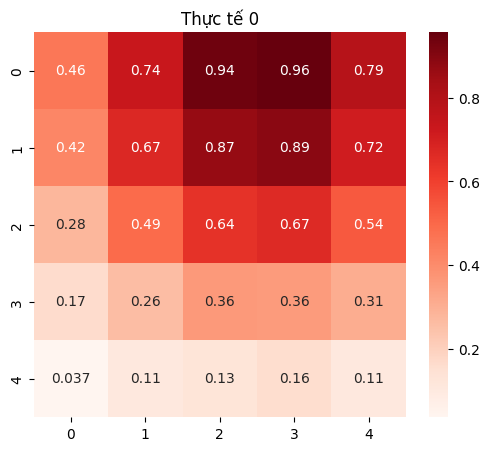

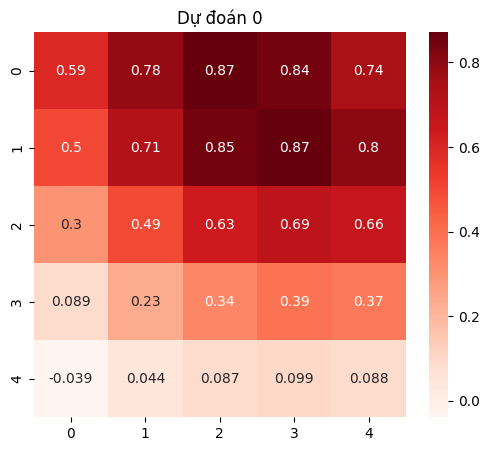

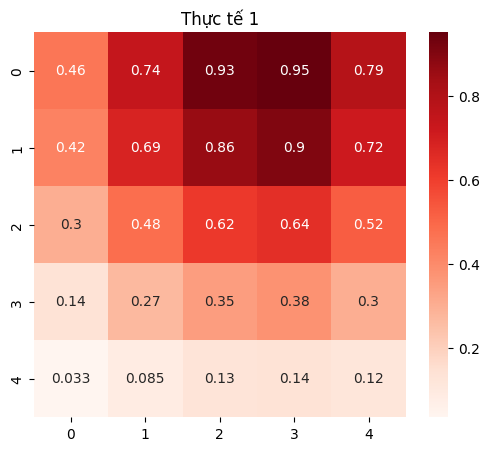

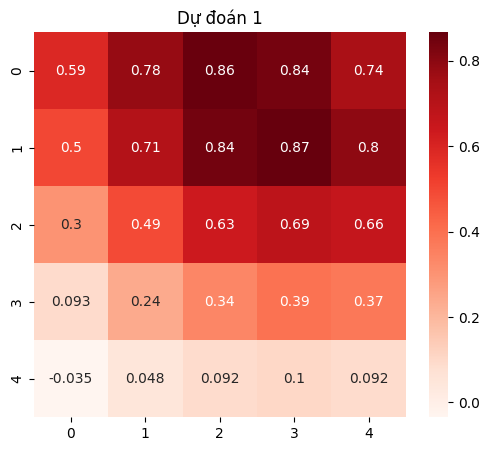

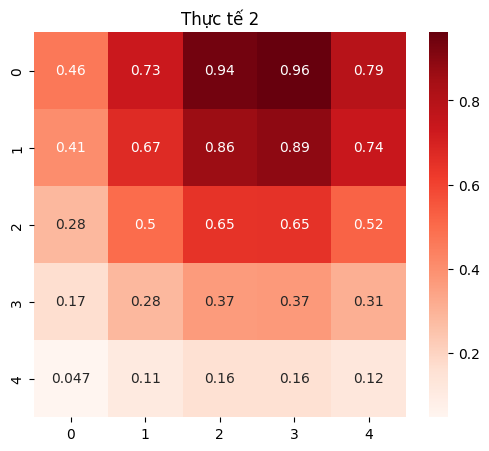

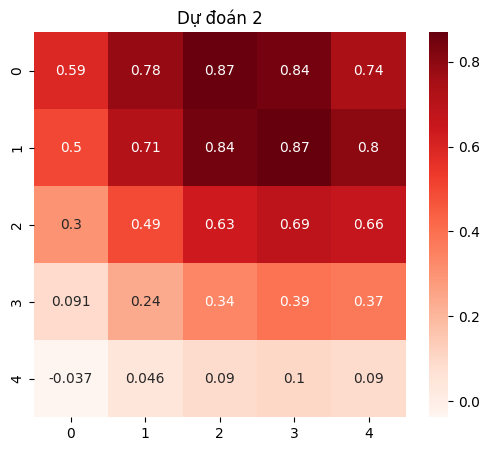

In [11]:
def show_heatmap(grid_data, title):
    dust_map = grid_data[:, :, 0]  # chỉ lấy bụi
    plt.figure(figsize=(6, 5))
    sns.heatmap(dust_map, annot=True, cmap='Reds')
    plt.title(title)
    plt.show()

# So sánh
for i in range(3):
    show_heatmap(y_test_grid[i], f"Thực tế {i}")
    show_heatmap(y_pred_grid[i], f"Dự đoán {i}")


In [12]:
model.save('air_pollution_lstm_model.h5')
